# Модель для классификации тарифов компании "Мегалайн"

## Получение и изучение данных

### Поставленная задача и исходные данные

**Заказчик: оператор мобильной связи «Мегалайн»**

Т.к. многие клиенты пользуются архивными тарифами, то заказчику требуется построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

Предоставлены данные о поведении клиентов, которые уже перешли на тарифы «Смарт» или «Ультра». Данные уже прошли преобработку ранее.

<ins>**Задача: построить модель для задачи классификации, выбирающую подходящий тариф с максимальной точностью (`accuracy`).**</ins>

Необходимо довести долю правильных ответов по крайней мере до 0.75 и проверить точность (`accuracy`) на тестовой выборке.

**Описание данных**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.

Известно:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

### Обзор данных

<ins>Импорт библиотек</ins>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # отключаем предупреждения
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

<ins>Чтение файлов с данными</ins>

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

<ins>Изучение общей информации о данных</ins>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Данные уже прошли преобработку ранее, о чём свидетельствует общая информация о данных. Замену типов данных с `float` на `int` не считаю необходимой, т.к. после подобных замен возможна некорректная работа некоторых функций. На анализ данная замена не влияет.

Посмотрим на графическое отображение взаимосвязей в данных и влияние параметров на целевой признак.

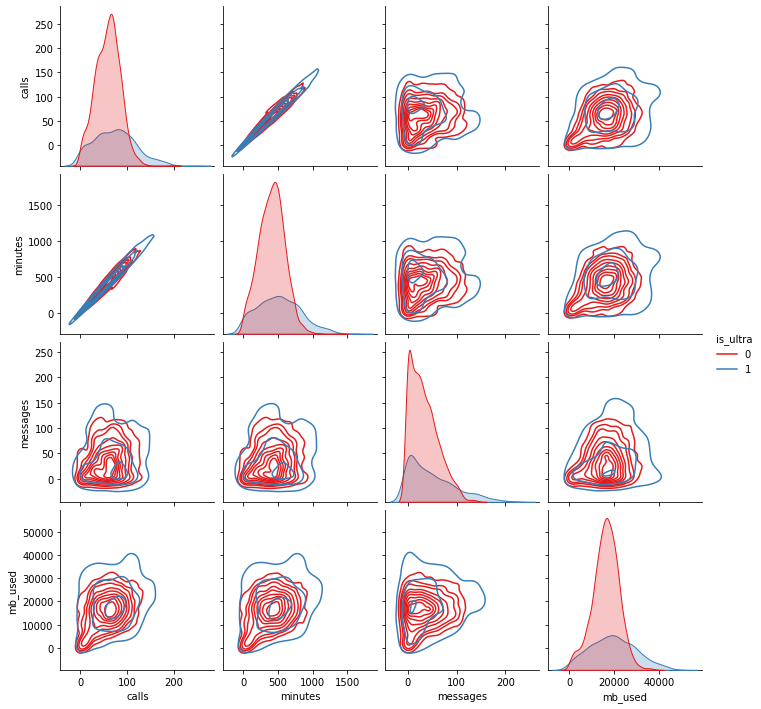

In [6]:
sns.pairplot(df, hue='is_ultra', palette='Set1', kind = 'kde');

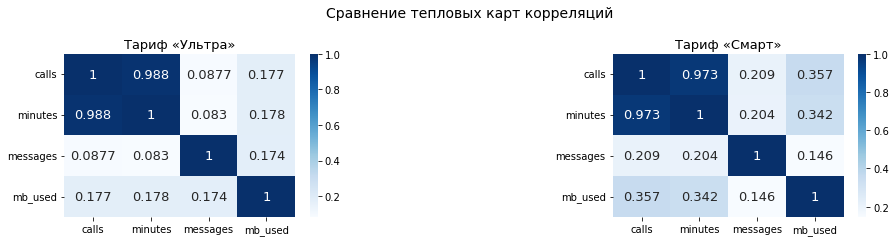

In [7]:
fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(15,3))
fig.subplots_adjust(wspace=0.9)

fig.suptitle('Сравнение тепловых карт корреляций', y = 1.1, fontsize = 14)

ax0.set_title('Тариф «Ультра»', fontsize=13);
ax1.set_title('Тариф «Смарт»', fontsize=13);

sns.heatmap(df[df['is_ultra']==1].set_index('is_ultra').corr(),
            annot=True, annot_kws={"size": 13}, cmap="Blues", fmt ='.3g', ax=ax0)

sns.heatmap(df[df['is_ultra']==0].set_index('is_ultra').corr(),
            annot=True, annot_kws={"size": 13}, cmap="Blues", fmt ='.3g', ax=ax1);

<ins>Оценка по диаграммам рассеяния и тепловым картам корреляций:</ins>
- наблюдается высокая положительная корреляция между количеством звонков и минутами, что логично
- трафик сообщений слабо зависит от трафика интернета, в современном мире это так, если человек активно пользуется интернетом, то он и пишет сообщения через интернет-мессенджеры и наоборот.
- вся корреляция положительная, что в целом говорит о том, что чем интенсивнее клиент пользуется тарифом, тем больше он пользуется всеми услугами тарифа, что также логично

Различия:

тариф «Смарт»
- трафик сообщений и интернета средне зависит от количества звонков и минут

тариф «Ультра»
- трафик сообщений и интернета слабо зависит от количества звонков и минут

Различия объясняются предпочтениями целевой аудитории каждого тарифа. Т.к. тариф «Ультра» дороже, то пользователи данного тарифа меньше заботятся о трафике, чем пользователи тарифа «Смарт».

<ins>Оценка по гистограммам трафика (диагональ):</ins>
- `сalls`, `minutes`, `messages` - ассиметриченое распределение со скошенным вправо набором данных, медиана меньше среднего
- `mb_used` - нормальное распределение, медиана и среднее близки

Пользователей с тарифом «Смарт» (0) значительно больше, чем пользователей с тарифом «Ультра» (1).

Доля тарифов:

In [8]:
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

<ins>Итог</ins>

Информация полученная на основании графического анализа не выявила некорректности в предоставленных данных.

## Разделение исходных данных на обучающую, валидационную и тестовую выборки.

Разделим исходные данные на обучающую, валидационную и тестовую выборки.

In [9]:
df_train, df_valid = train_test_split(df, test_size=0.4, random_state=12345)
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=12345)

In [10]:
df_train.shape

(1928, 5)

In [11]:
df_valid.shape

(643, 5)

In [12]:
df_test.shape

(643, 5)

## Исследование качества разных моделей при изменении гиперпараметров

Создадим переменные для признаков и целевого признака для обучающей, валидационной и тестовой выборок

In [13]:
features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']
features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']
features_test = df_test.drop('is_ultra', axis=1)
target_test = df_test['is_ultra']

Доля правильных ответов для всех моделей должна быть выше 0.75 по требованию заказчика. 

Для постоянства результата для всех моделей зададим `random_state`, равный 12345.

 <ins>Дерево решений</ins>

Обучим модель дерева решений:
- поменяем гиперпараметр `max_depth` (максимально допустимая глубина дерева) в цикле
- для каждого значения гиперпараметра вычислим качество (значение `accuracy` на валидационной выборке) 

In [14]:
depth_range = range(1, 30)
accuracy_list=[]

for depth in depth_range:
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # создание модели со различными значениями max_depth
    model.fit(features_train, target_train) # обучение модели на тренировочной выборке
    predictions_valid = model.predict(features_valid) # предсказания на валидационной выборке
    accuracy_list.append(accuracy_score(target_valid, predictions_valid).round(3)) # качество (точность)    
tree_df = pd.DataFrame({'max_depth': list(depth_range), 'accuracy':accuracy_list})
tree_df.sort_values(by='accuracy', ascending=False).reset_index(drop=True).head()

,max_depth,accuracy
0,3,0.785
1,6,0.784
2,2,0.782
3,7,0.782
4,9,0.782


Для наглядности отобразим результаты графически в виде столбчатой диаграммы.

Т.к. операция будет повторяться далее для других моделей, создадим функцию `bar_model`:
- `model_df` - датафрейм качества соответствующей модели
- `model_x` - изменяемый гиперпараметр
- `y_min`, `y_max` - границы точности (`accuracy` по оси y)

In [15]:
def bar_model(model_df, model_x, y_min, y_max):
    sns.set_style('darkgrid')    
    sns.set(font_scale=1.1)
    plot = model_df.plot.bar(y='accuracy',
                             x=model_x,
                             figsize=(20, 6),
                             ec='black',
                             width=0.5,
                             ylim=(y_min, y_max),
                             fontsize=13,
                             color='lightseagreen',
                             alpha=0.7)
    
    for rect in plot.patches:
        height = rect.get_height()
        plot.text(rect.get_x() + rect.get_width()/2, 1.001*height, round(height, 3), ha='center', va='bottom')
    
    plt.title('Сравнение качества модели при разных гиперпараметрах', fontsize=15);

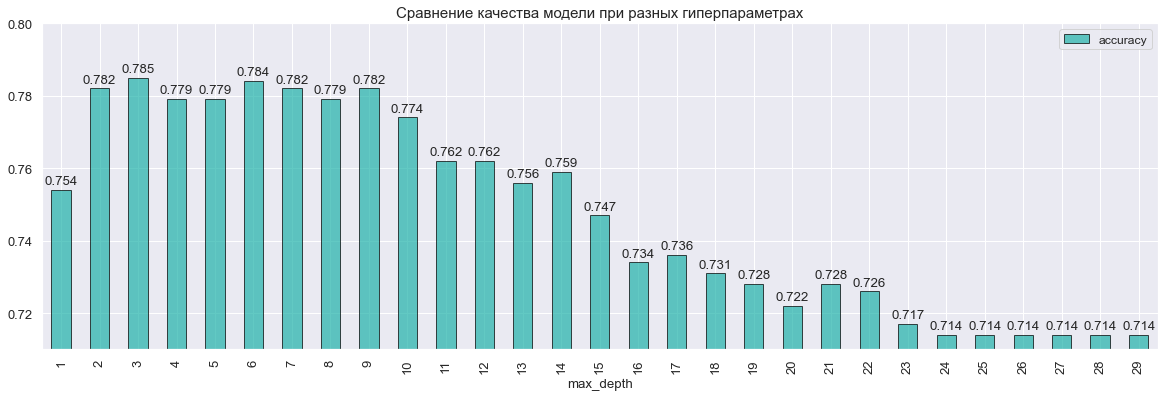

In [16]:
bar_model(tree_df, 'max_depth', 0.71, 0.8)

При использовании **дерева решений**:
- наибольшее значение точности `accuracy` = 0.785 при максимально допустимой глубине дерева `max_depth` = 3
- наилучшее качество достигается при максимально допустимой глубине дерева 2≤`max_depth`≤9
- `max_depth`=1 - недообучение, `max_depth`>9 - переобучение

 <ins>Случайный лес</ins>

Обучим модели случайного леса с различным числом деревьев:
- разделим тренировочную и валидационную выборки
- при инициализации модели укажем число деревьев (`n_estimators`) равное состоянию счётчика циклов — est
- обучим модель на тренировочной выборке
- для каждого значения гиперпараметра вычислим качество (значение `accuracy`) на валидационной выборке 

In [17]:
est_range = range(1, 30)
accuracy_list=[]

for est in est_range:
    model = RandomForestClassifier(random_state=12345, n_estimators=est) # создание модели с различным количеством деревьев
    model.fit(features_train, target_train) # обучение модели на тренировочной выборке
    accuracy_list.append(model.score(features_valid, target_valid).round(3)) # расчёт качества модели на валидационной выборке

forest_df = pd.DataFrame({'n_estimators': list(est_range), 'accuracy':accuracy_list})
forest_df.sort_values(by='accuracy', ascending=False).reset_index(drop=True).head()

,n_estimators,accuracy
0,23,0.795
1,21,0.793
2,18,0.793
3,24,0.790
4,19,0.788


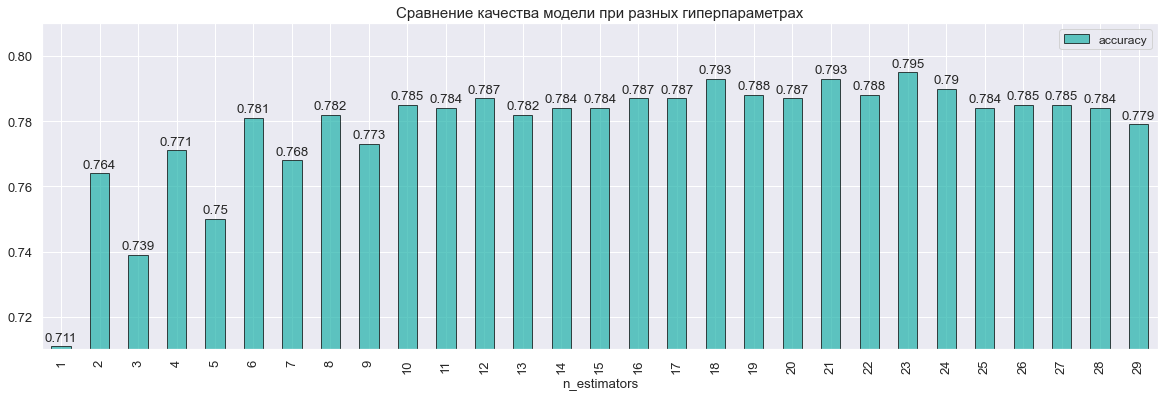

In [18]:
bar_model(forest_df, 'n_estimators', 0.71, 0.81)

При использовании **случайного леса**:
- наибольшее значение точности `accuracy` = 0.795 при максимальном числе деревьев `n_estimators` = 23
- наилучшее качество достигается при максимальном числе деревьев 8≤`n_estimators`≤28
- при `n_estimators`<8 - возможно недообучение
- про переобучение ничего определенного сказать нельзя, т.к. даже при максимальном числе деревьев `n_estimators`>29 получаются неплохие результаты

 <ins>Логистическая регрессия</ins>

Обучим модель логистической регрессии:

- добавим гиперпараметр `solver`, позволяющий выбрать алгоритм, который будет строить модель
- добавим гиперпараметр `max_iter`- максимальное количество итераций обучения
- для каждой пары значений гиперпараметров вычислим качество (`accuracy`) на валидационной выборке 

In [19]:
solv_iter = {'newton-cg':10000, 'lbfgs': 1000, 'liblinear': 1000, 'sag': 3000, 'saga': 5000,}
accuracy_list=[]

for key, value in solv_iter.items():
    model = LogisticRegression(random_state=12345, solver=key, max_iter=value) # создание модели с различными гиперпараметрами
    model.fit(features_train, target_train) # обучение модели на тренировочной выборке
    accuracy_list.append(model.score(features_valid, target_valid).round(3)) # качество (точность)

logistic_df = pd.DataFrame({'solver': list(solv_iter), 'max_iter': list(solv_iter.values()), 'accuracy':accuracy_list})
logistic_df.sort_values(by='accuracy', ascending=False).reset_index(drop=True)

,solver,max_iter,accuracy
0,newton-cg,10000,0.756
1,lbfgs,1000,0.711
2,liblinear,1000,0.709
3,sag,3000,0.708
4,saga,5000,0.708


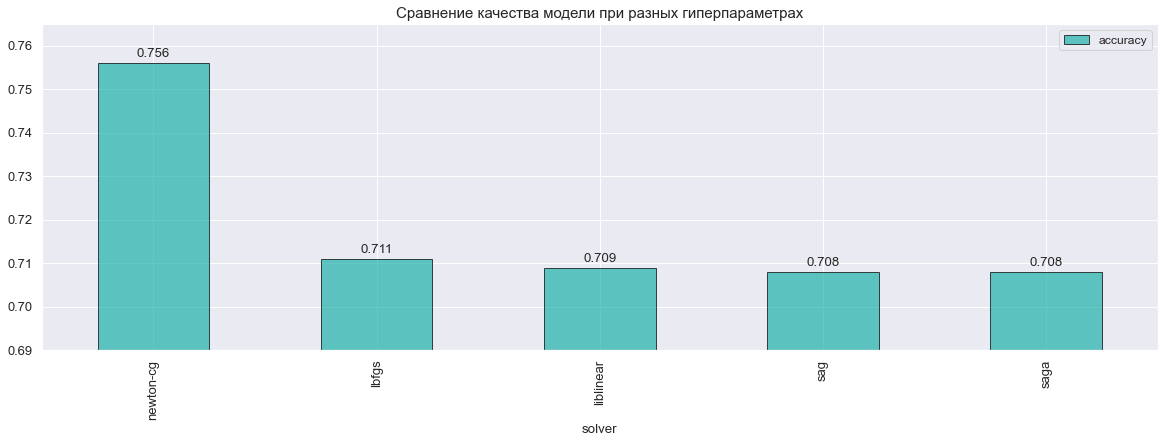

In [20]:
bar_model(logistic_df, 'solver', 0.69, 0.765)

При использовании **логистической регрессии**:
- наибольшее значение точности `accuracy` = 0.756 при алгоритме `newton-cg` для гиперпараметра `solver`
- остальные алгоритмы уступают в точности

Сравнение результатов

In [21]:
best_accuracy = pd.DataFrame({'model': ['tree_df','forest_df','logistic_df'],
                            'accuracy':[tree_df['accuracy'].max(),forest_df['accuracy'].max(),logistic_df['accuracy'].max()]})
best_accuracy.set_index('model').sort_values(by='accuracy', ascending=False)

,accuracy
model,
forest_df,0.795
tree_df,0.785
logistic_df,0.756


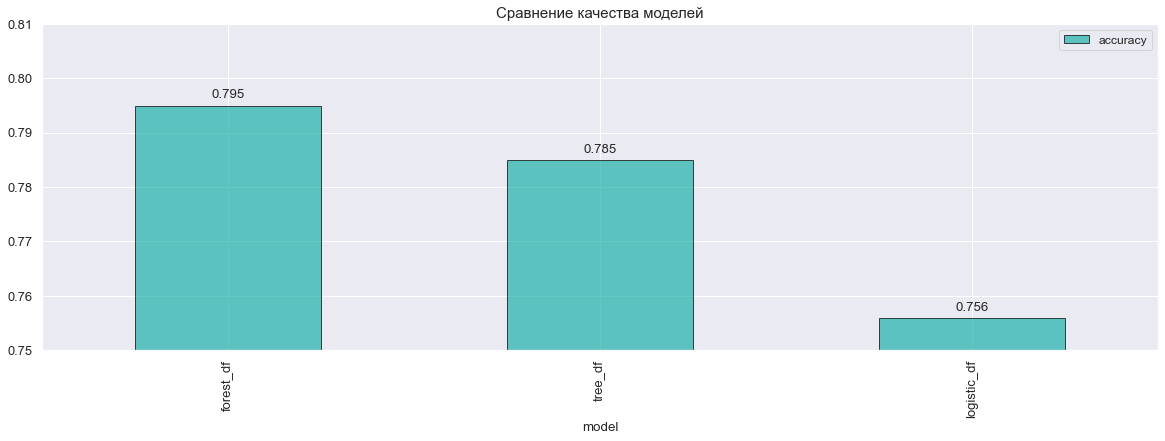

In [22]:
bar_model(best_accuracy.sort_values(by='accuracy', ascending=False).reset_index(drop=True), 'model', 0.75, 0.81)
plt.title('Сравнение качества моделей', fontsize=15);

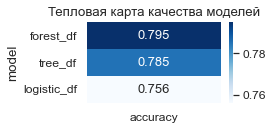

In [23]:
plt.figure(figsize=(3,1.5))
plt.title('Тепловая карта качества моделей')
sns.heatmap(best_accuracy.set_index('model').sort_values(by='accuracy', ascending=False),
            annot=True, annot_kws={"size": 13}, cmap="Blues", fmt ='.3g');

Вывод.

- доля правильных ответов для всех моделей выше 0.75

- наилучшие результаты показала модель **случайный лес**, на втором месте - **дерево решений**, на третьем - **логистическая регрессия**

## Проверка качества модели на тестовой выборке

<ins>Дерево решений</ins>

In [24]:
tree_df.sort_values(by='accuracy', ascending=False).reset_index(drop=True).head(1)

,max_depth,accuracy
0,3,0.785


In [25]:
model = DecisionTreeClassifier(random_state=12345, max_depth=3) # создание модели
model.fit(features_train, target_train) # обучение модели на тренировочной выборке
prediction_test = model.predict(features_test) # предсказания на тестовой выборке
accuracy_tree=accuracy_score(target_test, prediction_test).round(3) # качество (точность)    

print('точность', accuracy_tree)

точность 0.779


 <ins>Случайный лес</ins>

In [26]:
forest_df.sort_values(by='accuracy', ascending=False).reset_index(drop=True).head(1)

,n_estimators,accuracy
0,23,0.795


In [27]:
model = RandomForestClassifier(random_state=12345, n_estimators=23) # создание модели
model.fit(features_train, target_train) # обучение модели на тренировочной выборке
accuracy_forest = model.score(features_test, target_test).round(3) # расчёт качества модели на тестовой выборке
print('точность', accuracy_forest)

точность 0.781


 <ins>Логистическая регрессия</ins>

In [28]:
logistic_df.sort_values(by='accuracy', ascending=False).reset_index(drop=True).head(1)

,solver,max_iter,accuracy
0,newton-cg,10000,0.756


In [29]:
model = LogisticRegression(random_state=12345, solver='newton-cg', max_iter=10000) # создание модели
model.fit(features_train, target_train) # обучение модели на тренировочной выборке
accuracy_logistic = model.score(features_test, target_test).round(3) ## расчёт качества модели на тестовой выборке
print('точность', accuracy_logistic)

точность 0.739


Сравнение результатов

In [30]:
best_accuracy = pd.DataFrame({'model': ['tree_df','forest_df','logistic_df'],
                            'accuracy':[accuracy_tree, accuracy_forest,accuracy_logistic]})
best_accuracy.set_index('model').sort_values(by='accuracy', ascending=False)

,accuracy
model,
forest_df,0.781
tree_df,0.779
logistic_df,0.739


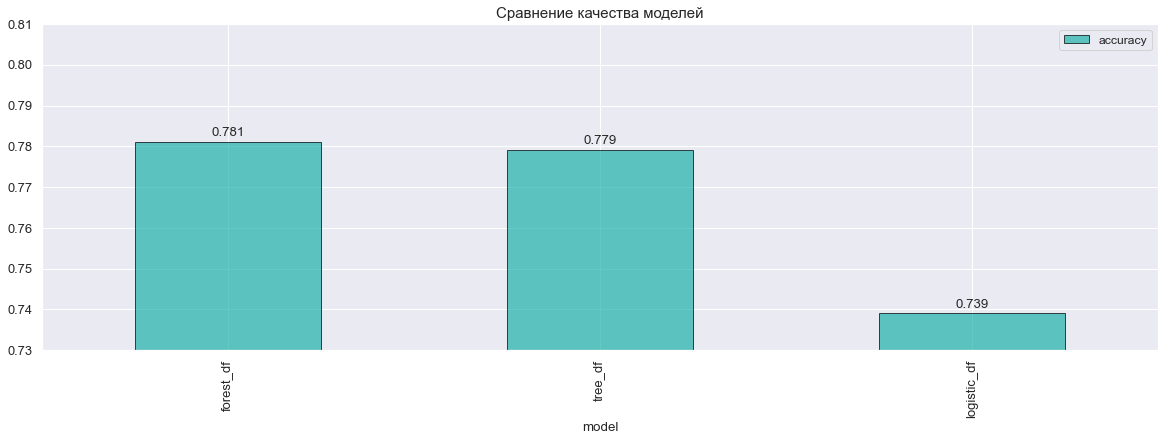

In [31]:
bar_model(best_accuracy.sort_values(by='accuracy', ascending=False).reset_index(drop=True), 'model', 0.73, 0.81)
plt.title('Сравнение качества моделей', fontsize=15);

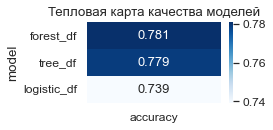

In [32]:
plt.figure(figsize=(3,1.5))
plt.title('Тепловая карта качества моделей')
sns.heatmap(best_accuracy.set_index('model').sort_values(by='accuracy', ascending=False),
            annot=True, annot_kws={"size": 13}, cmap="Blues", fmt ='.3g');

Вывод.

- доля правильных ответов для моделей **случайный лес** и **дерево решений** выше 0.75, для модели **логистическая регрессия** - ниже

- наилучшие результаты показала модель **случайный лес**, на втором месте - **дерево решений**, на третьем - **логистическая регрессия**

## Выбор лучшей модели

Лучшая модель (модель с наибольшей точностью) - **случайный лес**.

Сохраним результаты в переменную `model_best`.

In [33]:
model_best = RandomForestClassifier(random_state=12345, n_estimators=23)
model_best.fit(features_train, target_train)
accuracy_valid = model_best.score(features_valid, target_valid).round(3)
accuracy_test = model_best.score(features_test, target_test).round(3)
print('точность на валидационной выборке', accuracy_valid)
print('точность на тестовой выборке', accuracy_test)

точность на валидационной выборке 0.795
точность на тестовой выборке 0.781


Дополнительно проверим точность на выборке, объединяющей валидационную и тренировочную

Объединим валидационную и тренировочную выборки в `df_valid_test`

In [34]:
df_valid_test = df_valid.merge(df_test, on=['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], how='outer')
df_valid_test.shape

(1286, 5)

Создадим переменные для признаков и целевого признака для выборки `df_valid_test`

In [35]:
features_valid_test = df_valid_test.drop('is_ultra', axis=1)
target_valid_test = df_valid_test['is_ultra']

Проверим точность

In [36]:
accuracy_valid_test = model_best.score(features_valid_test, target_valid_test).round(3)
print('точность на выборке, объединяющей валидационную и тренировочную,', accuracy_valid_test)

точность на выборке, объединяющей валидационную и тренировочную, 0.788


Точность выше, чем на тренировочной выборке, но ниже, чем на валидационной.

## Проверка модели на вменяемость

Проверим на вменяемость двумя способами:
- 1) сравнение лучшей модели со случайной
- 2) проверка лучшей модели на случайной выборке

### Cравнение лучшей модели со случайной

Используем классификатор `DummyClassifier`, делающий прогнозы, игнорируя входные функции.

Конкретное поведение базовой линии выбирается с помощью параметра `strategy`.

In [37]:
clf_dummy = DummyClassifier(strategy="most_frequent", random_state=42)
clf_dummy.fit(features_train, target_train)
accuracy_valid_dum = clf_dummy.score(features_valid, target_valid).round(3)
accuracy_test_dum = clf_dummy.score(features_test, target_test).round(3)
print('точность случайной модели на валидационной выборке', accuracy_valid_dum)
print('точность случайной модели на тестовой выборке', accuracy_test_dum)

точность случайной модели на валидационной выборке 0.706
точность случайной модели на тестовой выборке 0.684


In [38]:
accuracy_compare_1 = (pd.DataFrame({'accuracy': [accuracy_valid, accuracy_valid_dum, accuracy_test, accuracy_test_dum],
                                 'model_selection':['best_valid', 'random_valid', 'best_test', 'random_test']})
                    .set_index('model_selection'))

In [39]:
accuracy_compare_1

,accuracy
model_selection,
best_valid,0.795
random_valid,0.706
best_test,0.781
random_test,0.684


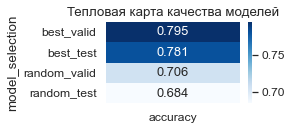

In [40]:
plt.figure(figsize=(3,1.5))
plt.title('Тепловая карта качества моделей')
sns.heatmap(accuracy_compare_1.sort_values(by='accuracy', ascending=False),
            annot=True, annot_kws={"size": 13}, cmap="Blues", fmt ='.3g');

`model_selection`:
- `best_valid` - лучшая модель, валидационная выборка
- `best_test` - лучшая модель, тестовая выборка
- `random_valid` - случайная модель, валидационная выборка
- `random_test` - случайная модель, тестовая выборка

Итог.

Лучшая модель показала более высокую точность, чем случайная, следовательно лучшая модель вменяема.

### Проверка лучшей модели на случайной выборке

Проверим точность при случайном заполнении целевого признака.

Создадим переменную для целевого признака случайной выборки.

In [41]:
target_valid_r = np.random.randint(0, 2, size=len(features_valid))
target_test_r = np.random.randint(0, 2, size=len(features_test))

In [42]:
accuracy_valid_r = model_best.score(features_valid, target_valid_r).round(3)
accuracy_test_r = model_best.score(features_test, target_test_r).round(3)
print('точность на валидационной выборке', accuracy_valid_r)
print('точность на тестовой выборке', accuracy_test_r)

точность на валидационной выборке 0.493
точность на тестовой выборке 0.479


In [43]:
accuracy_compare_2 = (pd.DataFrame({'accuracy': [accuracy_valid, accuracy_valid_r, accuracy_test, accuracy_test_r],
                                 'selection':['act_valid', 'random_valid', 'act_test', 'random_test']})
                    .set_index('selection'))
accuracy_compare_2

,accuracy
selection,
act_valid,0.795
random_valid,0.493
act_test,0.781
random_test,0.479


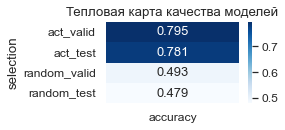

In [44]:
plt.figure(figsize=(3,1.5))
plt.title('Тепловая карта качества моделей')
sns.heatmap(accuracy_compare_2.sort_values(by='accuracy', ascending=False),
            annot=True, annot_kws={"size": 13}, cmap="Blues", fmt ='.3g');

`selection`:
- `act_valid` - актуальный датасет, валидационная выборка
- `act_test` - актуальный датасет, тестовая выборка
- `random_valid` - случайный датасет, валидационная выборка
- `random_test` - случайный датасет, тестовая выборка

Итог.

Лучшая модель, проверенная на актуальных данных, показала более высокую точность, чем лучшая модель, проверенная на случайных данных, следовательно модель вменяема.

## Вывод

По требованию заказчика построена модель для задачи классификации, выбирающая подходящий тариф с максимальной точностью.

Доля правильных ответов не ниже 0.75, точность проверена на тестовой выборке.

Модель сохранена в переменной `model_best`.